Eigenvalues of Jacobian 1: [-0.28833333+0.31215203j -0.28833333-0.31215203j]
time for sim =  0.03063201904296875 s
Eigenvalues of Jacobian 2: [0.00958333+0.4248331j 0.00958333-0.4248331j]


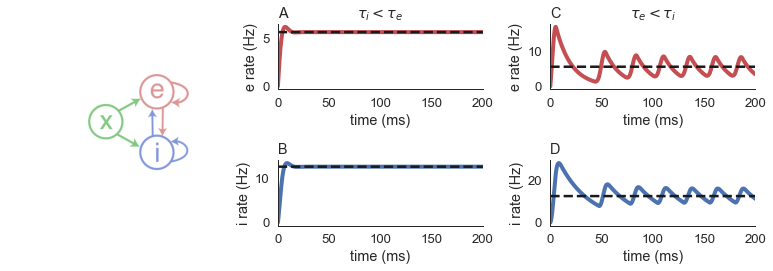

In [4]:
###############################################
## Import packages and specify some settings ##
###############################################
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This makes plots show up and look nice
%matplotlib inline
sns.set(context='paper',style='white',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.set_palette('muted')

# Keep this set to false unless you want to save figures and data
# (in which case you'll need to change some directories below)
SaveFigures=False
###############################################
###############################################

# For computing runtimes
from time import time as tm

# Seed random number generator so that
# we get the same results every time
# we run this code
np.random.seed(6)

# Discretized time
T=200
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)

# Use parameters from old spiking network simulations 
# to build W. This way, the fixed point rates will
# approximate steady-state rates in spiking net sims
Nx=2000
Ne=2000 
Ni=500 
jex=25
jix=17
jee=10
jei=-40
jie=30
jii=-60
pex=.1
pix=.1
pee=.1 
pei=.1 
pie=.1 
pii=.1
rx=5/1000
wex=jex*pex*Nx 
wix=jix*pix*Nx 
Wx=np.array([wex,wix])

# Entries of W 
wee=jee*pee*Ne 
wei=jei*pei*Ni 
wie=jie*pie*Ne
wii=jii*pii*Ni 
W=np.array([[wee, wei],  [wie, wii]])

# Mean-field external input
X=Wx*rx

# Time constants for rate equation
taue=30
taui=15
tau=np.array([taue,taui])


# Mean-field rate
# f-I curve fit from other file
data = np.load('./EIFfIcurve.npz',allow_pickle=True)
g=data['gfit']
theta=data['thetafit']
rFixedPoint=np.linalg.inv((1/g)*np.eye(2)-W)@(X-theta)

# Define f-I curve
def f(I):
    return g*(I-theta)*(I>theta)


# Define the  Jacobian
J=(1/tau)*(-np.eye(2)+g*W)
lam,_=np.linalg.eig(J)
print('Eigenvalues of Jacobian 1:',lam)

# Initialize rate
r=np.zeros((2,Nt))

# Euler loop
t0=tm()
for i in range(len(time)-1):
    r[:,i+1]=r[:,i]+(dt/tau)*(-r[:,i]+f(W@r[:,i]+X))

print('time for sim = ',tm()-t0,'s')



# Now re-run with excitation faster
taue2=15
taui2=30
tau2=np.array([taue2,taui2])
r2=np.zeros((2,Nt))
for i in range(len(time)-1):
    r2[:,i+1]=r2[:,i]+(dt/tau2)*(-r2[:,i]+f(W@r2[:,i]+X))
    

# Define the  Jacobian and compute eigenvalues
J2=(1/tau2)*(-np.eye(2)+g*W)
lam2,_=np.linalg.eig(J2)
print('Eigenvalues of Jacobian 2:',lam2)


# Make figure
plt.subplots(figsize=(11, 4))

plt.subplot(1,3,1)
im = plt.imread('EIRecurrentNet.png')
plt.imshow(im,interpolation='hanning',extent=(.4,.9,.25,.75))
plt.axis((0,1,0,1))
plt.axis('off')
#plt.title('A',loc='left')

plt.subplot(2,3,2)
plt.plot(time,1000*r[0,:],'r',LineWidth=4)
plt.plot(time,1000*rFixedPoint[0]+np.zeros_like(time),'k--')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('e rate (Hz)')
plt.title(r'$\tau_i<\tau_e$')
plt.title('A',loc='left')
sns.despine()

plt.subplot(2,3,5)
plt.plot(time,1000*r[1,:],'b',LineWidth=4)
plt.plot(time,1000*rFixedPoint[1]+np.zeros_like(time),'k--')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('i rate (Hz)')
plt.title('B',loc='left')
sns.despine()

plt.subplot(2,3,3)
plt.plot(time,1000*r2[0,:],'r',LineWidth=4)
plt.plot(time,1000*rFixedPoint[0]+np.zeros_like(time),'k--')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('e rate (Hz)')
plt.title(r'$\tau_e<\tau_i$')
plt.title('C',loc='left')
sns.despine()

plt.subplot(2,3,6)
plt.plot(time,1000*r2[1,:],'b',LineWidth=4)
plt.plot(time,1000*rFixedPoint[1]+np.zeros_like(time),'k--')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('i rate (Hz)')
plt.title('D',loc='left')
sns.despine()


plt.tight_layout()

# Save figure if needed
if SaveFigures:
      plt.savefig('../Figures/RecurrentRateNet.pdf')

